importação dos dados

In [3]:
import pandas as pd

uri_comentarios = 'https://media.githubusercontent.com/media/fabriciobedin/machine-learning/master/emotion_analyzer_by_words/imdb-reviews-pt-br.csv'
comentarios = pd.read_csv(uri_comentarios)
comentarios.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


alterando coluna de sentiment pra classificação, onde o sentimento negativo vai se tornar 0 e o positivo vai se tornar 1

In [5]:
classificacao = comentarios["sentiment"].replace(["neg", "pos"], [0,1])
comentarios["classificacao"] = classificacao
comentarios.head()


,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


utilizando o Count Vectorizer pra criar um bag of words, ele vai separar todas as palavras encontradas em cada frase.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Exemplo
textos = ["Assisti um filme ótimo", "Assisti um filme péssimo"]
vetorizar = CountVectorizer(lowercase = False)
bag_of_words = vetorizar.fit_transform(textos)
vetorizar.get_feature_names()

['Assisti', 'filme', 'péssimo', 'um', 'ótimo']

criando um datatable a partir desses dados de teste pra entender o funcionamento. Ao invés de armazenar os valores 0 e ficar ocupando memória, ele armazena um valor NaN que seria um valor nulo.

In [9]:
vetorizado = pd.SparseDataFrame(
    bag_of_words,
    columns = vetorizar.get_feature_names()
)
vetorizado

,Assisti,filme,péssimo,um,ótimo
0,1,1,NaN,1,1.0
1,1,1,1.0,1,NaN


Iniciando a classificação de sentimento com base na planilha importada.

In [11]:
vetorizar = CountVectorizer(lowercase = False, max_features = 50)
bag_of_words = vetorizar.fit_transform(comentarios["text_pt"])
print(bag_of_words.shape)

(49459, 50)


separando dados entre treino e teste com sklearn.model_selection e exibindo proporção separada

In [19]:
from sklearn.model_selection import train_test_split


treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              comentarios["classificacao"],
                                                              random_state = 42)
print('Treino: {treino}, Teste: {teste}'.format(treino = treino.shape, teste = teste.shape))

Treino: (37094, 50), Teste: (12365, 50)


criando modelo linear com logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

regressao_logistica = LogisticRegression(solver = "lbfgs")
regressao_logistica.fit(treino, classe_treino)
previsao_teste = regressao_logistica.predict_proba(teste)
print(previsao_teste)

[[0.25696739 0.74303261]
 [0.72224991 0.27775009]
 [0.70076066 0.29923934]
 ...
 [0.46019618 0.53980382]
 [0.46166722 0.53833278]
 [0.61777927 0.38222073]]


In [27]:
import numpy as np

previsao_teste_bol = previsao_teste[:,1] >= 0.5
previsao_teste_int = previsao_teste_bol.astype(np.int)

print('Previsão teste bol: {bol}\nPrevisão teste int: {int}'
      .format(bol = previsao_teste_bol, int = previsao_teste_int))

Previsão teste bol: [ True False False ...  True  True False]
Previsão teste int: [1 0 0 ... 1 1 0]


criando porcentagem de acerto do algorítmo

In [72]:
from sklearn.metrics import accuracy_score
accuracy_teste = accuracy_score(classe_teste, previsao_teste_int)
print('Accuracy: {accuracy}%'.format(accuracy = round(accuracy_teste*100, 2)))

Accuracy: 65.83%


visualizando palavras com wordcloud, vai exibir as palavras em um tamanho diferente conforme quantidade de vezes que elas aparecem.

In [0]:
%matplotlib inline

from wordcloud import WordCloud

todas_palavras = ' '.join([texto for texto in comentarios["text_pt"]])

nuvem_palavras = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(todas_palavras)

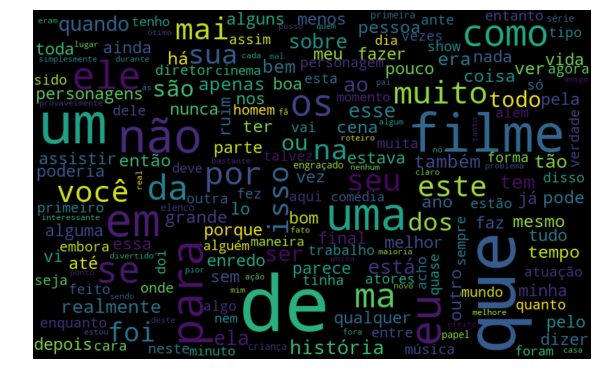

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize= (10, 7))
plt.imshow(nuvem_palavras, interpolation = 'bilinear')
plt.axis('off')
plt.show()

utilizando o query pra separar os comentários positivos dos negativos

In [0]:
comentarios_positivos = comentarios.query("sentiment == 'pos'")
comentarios_negativos = comentarios.query("sentiment == 'neg'")

exibindo wordcloud apenas com palavras positivas 

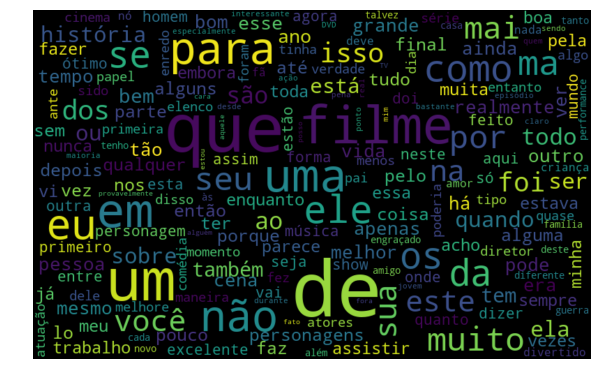

In [44]:
palavras_pos = ' '.join([texto for texto in comentarios_positivos["text_pt"]])
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                           collocations=False).generate(palavras_pos)
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

exibindo wordcloud apenas com palavras negativas

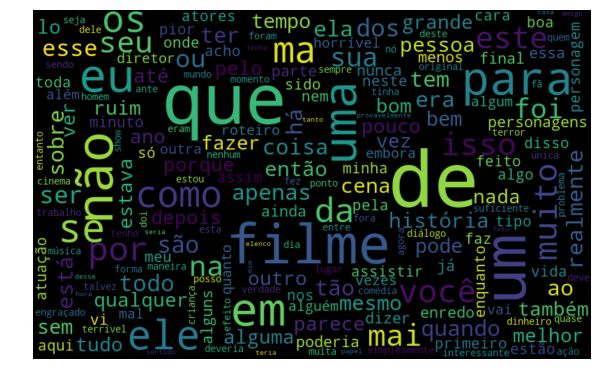

In [45]:
palavras_neg = ' '.join([texto for texto in comentarios_negativos["text_pt"]])
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                           collocations=False).generate(palavras_neg)
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Utilizando um recurso de tokenização do NLTK. Ele separa uma frase em palavras, levando em consideração algum tipo de separador. No exemplo abaixo vou utilizar uma frase e separar por espaços em branco.

In [46]:
from nltk import tokenize

frase = "Bem vindo ao mundo do PLN"
token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(frase)
print(token_frase)

['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLN']


agora vamos aplicar ao nosso modelo pra separar as palavras e exibir a frequência que elas aparecem nos comentários

In [50]:
import nltk

todas_palavras = ' '.join([texto for texto in comentarios["text_pt"]])
frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
df_frequencia = pd.DataFrame({"Palavras": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = 13)
df_frequencia

,Palavras,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


utilizando o SeaBorn pra criar um gráfico dessas palavras e frequencia.

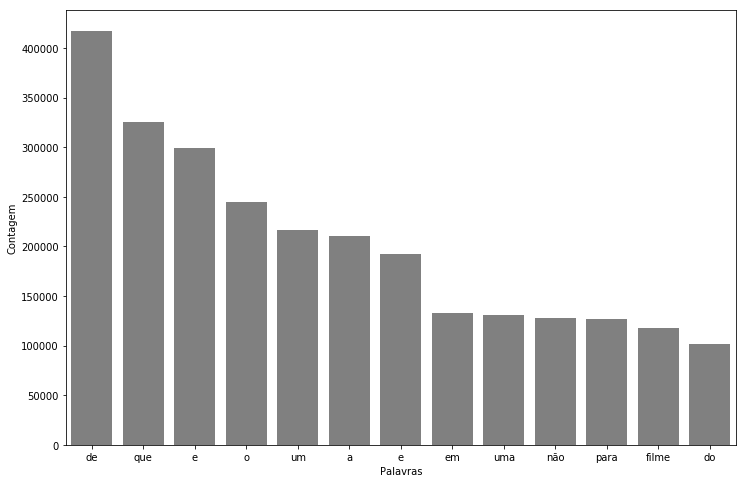

In [51]:
import seaborn as sns

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequencia, x= "Palavras", y = "Frequência", color = 'gray')
ax.set(ylabel = "Contagem")
plt.show()

como vocês podem ver, as palavras mais utilizadas não vão nos ajudar a distinguir o sentimento do comentário, devemos eliminar essas palavras. Vamos utilizar o recurso stopwords do NLTK.

Abaixo vamos criar uma função que percore cada comentário, separa as palavras e testa se é uma palavra relevante ou não, e gera uma nova coluna recriando o comentário sem as palavras irrelevantes

In [55]:
import nltk
nltk.download('stopwords')

palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
frase_processada = list()

for comentario in comentarios["text_pt"]:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(comentario)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
comentarios["tratamento_1"] = frase_processada
comentarios.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text_en,text_pt,sentiment,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este é exemplo motivo maioria filmes ação mesm...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão é palavra apropriada eles, ..."


definindo uma função pra criar a nuvem de palavras

In [0]:
def nuvem_palavras(texto, coluna_texto, sentimento):
    texto_separado = texto.query("sentiment == '{sentimento}'".format(sentimento = sentimento))
    todas_palavras = ' '.join([texto for texto in texto_separado[coluna_texto]])
    nuvem_palavras = WordCloud(width = 800, height = 500,
                                max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

exibindo nuvem de palavras negativas depois de ter removido as palavras desnecessárias

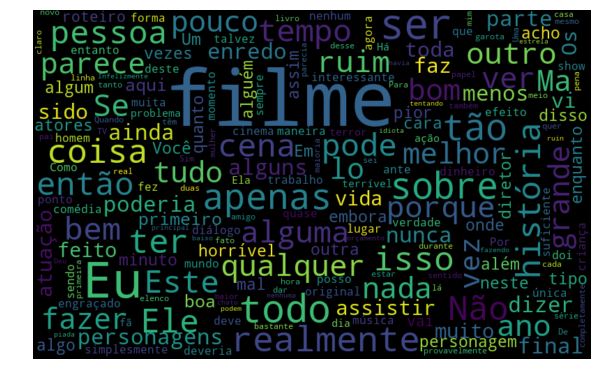

In [61]:
nuvem_palavras(comentarios, 'tratamento_1', 'neg')

exibindo núvem de palavras positivas depois de ter removido as desnecessárias

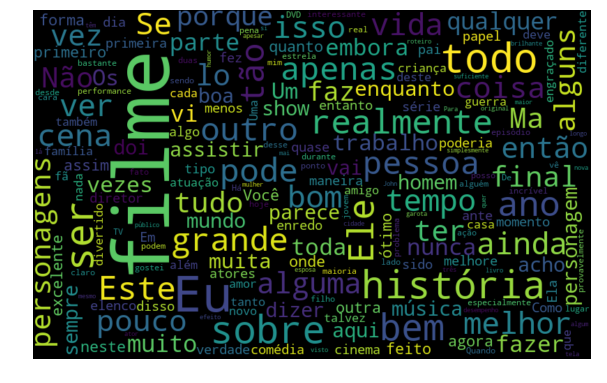

In [62]:
nuvem_palavras(comentarios, 'tratamento_1', 'pos')

criando função pra criar gráfico pareto

In [0]:
def grafico_pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

exibindo gráfico de palavras depois de ter removido as desnecessárias

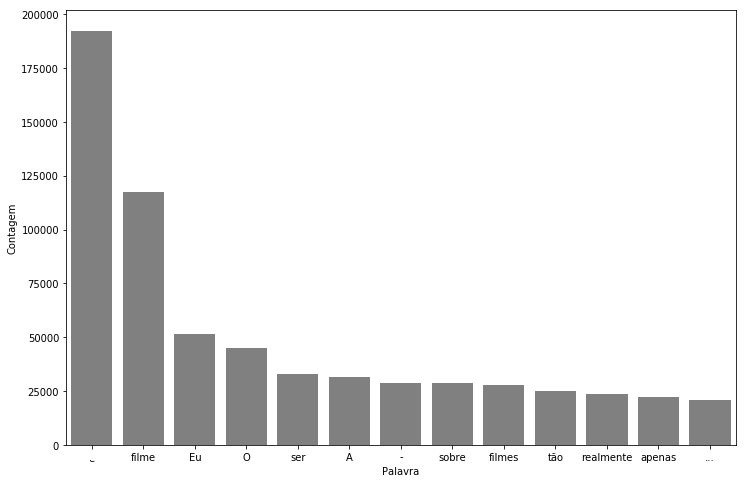

In [66]:
grafico_pareto(comentarios, "tratamento_1", 13)

criando função pra classificar o texto com a regreção logística

In [0]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                 texto[coluna_classificacao],
                                                                 random_state = 42)
    
    regressao_logistica = LogisticRegression(solver="lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    
    return regressao_logistica.score(teste, classe_teste)

exibindo a porcentagem de acerto após remover as palavras desnecessárias

In [71]:
accuracy_teste = classificar_texto(comentarios, "tratamento_1", "classificacao")
print('Accuracy: {accuracy}%'.format(accuracy = round(accuracy_teste*100, 2)))

Accuracy: 66.07%


otimizando a análise